In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from hessian import *
import operator
torch.manual_seed(1)


In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


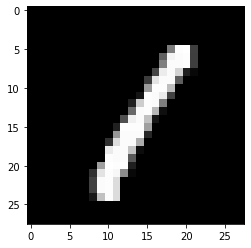

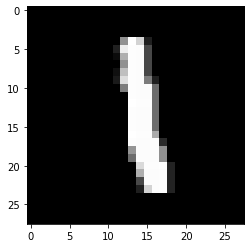

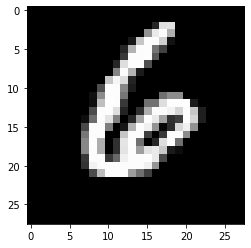

In [4]:
initial_train_data=[]
initial_train_label=[]
initial_test_data=[]

for i in range(0,1):
    for j in range(100):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    

test_6=train_dict[6][0]
test_1=train_dict[1][1]
    
print(initial_train_label)

plt.imshow(train_dict[1][0].reshape(28,28), cmap='gray', interpolation='none')
plt.show()

plt.imshow(test_1.reshape(28,28), cmap='gray', interpolation='none')
plt.show()
plt.imshow(test_6.reshape(28,28), cmap='gray', interpolation='none')
plt.show()

In [5]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
# train_x=torch.stack([data for (data, target) in train_data])
# train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 20)
        self.loss=nn.CrossEntropyLoss()
        self.final_weight=torch.nn.Parameter(nn.init.xavier_uniform_(torch.empty(20, 10),0.1))
#         for name, param in self.named_parameters():
#             if param.requires_grad:
#                 print (name, param.data)

        self.optimizer = optim.Adam(self.parameters(), lr=0.0005)
        self.optimizer_final = optim.Adam([self.final_weight], lr=0.0005)
    
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    def forward(self, x):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x= torch.matmul(x,self.final_weight)
        return x
    
    def predictive_distribution_entropy(self,x):
        final_weight_samples=self.posterior.sample().view(20,10)
#         print(final_weight_samples)
#         print(self.posterior.mean)
        final_weight_samples=self.posterior.sample([100]).view(100,20,10).permute(0, 2, 1)

#         final_weight_samples=self.posterior.mean.repeat([100,1]).view(100,20,10).permute(0, 2, 1)
#         print(final_weight_samples.size())
        feature_of_data=self.feature_forward(x)[0]
#         print(feature_of_data.size())
        output_logit=final_weight_samples@feature_of_data
#         print(output_logit.size())
        # output_probs=torch.exp(output_logit)
#         print(output_logit)
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        sample=output_dis.sample([100]).reshape([-1,1])
#         print(sample)
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
#         print(entropy)
        
        return entropy
        
    def predict(self,x):
        with torch.no_grad():
            output = torch.exp(self.forward(x))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
    
    def pre_train(self,x,label):
        train_losses = []
#         if x.size(0)>100:
#             for it in range(0,500):
#                 index=np.random.choice(x.size(0),100)
#                 self.optimizer.zero_grad()
#                 output = self.forward(x[index])
#                 #loss = F.nll_loss(output,label[index])
#                 loss = self.loss(output,label[index])+0.1*torch.norm(self.final_weight,2)
#                 loss.backward()
#                 self.optimizer.step()
#                 train_losses.append(loss.item())
#             for it in range(0,500):
#                 index=np.random.choice(x.size(0),100)
#                 self.optimizer.zero_grad()
#                 output = self.forward(x[index])
#                 #loss = F.nll_loss(output,label[index])
#                 loss = self.loss(output,label[index])+0.1*torch.norm(self.final_weight,2)
#                 loss.backward()
#                 self.optimizer.step()
#                 train_losses.append(loss.item())
        
#         else:    
        for it in range(0,100):
            self.optimizer.zero_grad()
            output = self.forward(x)
            loss = 100*self.loss(output,label)+100*torch.norm(self.final_weight,2)
            loss.backward()
            self.optimizer.step()
            train_losses.append(loss.item())
        for it in range(0,500):
            self.optimizer.zero_grad()
            output = self.forward(x)
            loss = 100*self.loss(output,label)+100*torch.norm(self.final_weight,2)
            loss.backward()
            self.optimizer_final.step()
            train_losses.append(loss.item())
#                 print(self.final_weight[0])
        plt.plot(train_losses)
        plt.show()
    
    
    def get_posterior(self,x,label):
        output = self.forward(x)
        loss = 100*self.loss(output,label)+100*torch.norm(self.final_weight,2)
        hessian_w=hessian(loss,self.final_weight)#+torch.eye(200)*1e-6
        hessian_inverse=torch.inverse(hessian_w)
        print(torch.diag(hessian_inverse))
        self.posterior=torch.distributions.multivariate_normal.MultivariateNormal(loc=self.final_weight.reshape(-1),covariance_matrix=hessian_inverse)
        return self.posterior

        
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

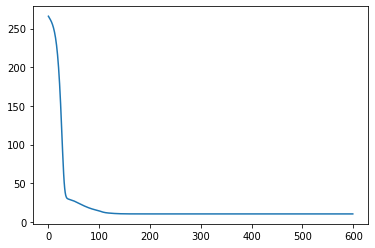

In [60]:
active_bnn = Net()
active_bnn.pre_train(initial_train_data_tensor,initial_train_label_tensor)



In [61]:
posterior=active_bnn.get_posterior(initial_train_data_tensor,initial_train_label_tensor)

tensor([0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0008, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 

In [94]:
print(active_bnn.predictive_distribution_entropy(train_dict[0][2]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][4]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][9]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][0]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][17]))
print(active_bnn.predictive_distribution_entropy(train_dict[3][13]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][0]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][3]))
print(active_bnn.predictive_distribution_entropy(train_dict[7][3]))

tensor(0.1755, grad_fn=<NegBackward>)
tensor(0.2202, grad_fn=<NegBackward>)
tensor(0.2215, grad_fn=<NegBackward>)
tensor(0.6486, grad_fn=<NegBackward>)
tensor(0.4361, grad_fn=<NegBackward>)
tensor(0.3933, grad_fn=<NegBackward>)
tensor(0.6798, grad_fn=<NegBackward>)
tensor(0.6198, grad_fn=<NegBackward>)
tensor(0.8537, grad_fn=<NegBackward>)


In [ ]:
# final_weight_samples=posterior.sample([100]).view(100,20,10).permute(0, 2, 1)
# print(final_weight_samples.size())
# feature_of_data=active_bnn.feature_forward(test_1)[0]
# print(feature_of_data.size())
# output_logit=final_weight_samples@feature_of_data
# print(output_logit.size())
# # output_probs=torch.exp(output_logit)
# output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
# sample=output_dis.sample([10]).reshape([-1,1])
# print(sample.size())
# entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
# print(entropy)

In [ ]:
mixture_of_categorical=active_bnn.predictive_distribution(test_1,posterior)